In [1]:
#!pip install -U scikit-learn
#!pip install autograd

# 1st Assignment: NN's from Scratch

The objective is to build from scratch a neural network to perform  classification. Let's firt consider the follwing 2-class dataset:

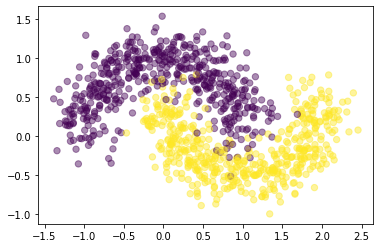

In [2]:
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import autograd.numpy as np
from autograd import grad
from autograd.misc import flatten

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)

# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(1000, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, alpha=0.45)

We will use a **3-layer classification neural network** with one input layer, one hidden layer, and one output layer. 

The number of nodes in the input layer will be determined by the dimensionality of our data (2). Similarly, the number of nodes in the output layer is determined by the number of classes $C$ we have (also 2). 

Our network makes predictions using forward propagation, which is just a bunch of matrix multiplications and the application of the activation function $\sigma$. 

If $x$ is the input to our network then we calculate our prediction $\hat{y}$ as follows:

$$ z_1 = x W_1 + b_1 $$
$$ a_1 = \sigma(z_1) $$
$$ z_2 = a_1 W_2 + b_2$$
$$ y = \mbox{softmax}({z_2})$$

where $y$ is a multidimensional vector representing a probability distribution over classes, $\sigma$ is a non linear function and $W_1, b_1, W_2, b_2$ are parameters of our network, which we need to learn from our training data. You can think of the parameters $W$ as matrices transforming data between layers of the network. 

Looking at the matrix multiplications above we can figure out the dimensionality of these matrices in our problem. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. 

The last layer is a `softmax` function. The softmax function is a generalization of the logistic function to multiple dimensions. It is used to normalize the output of a network to a probability distribution over predicted output classes.

The softmax function takes as input a vector $C$ of real numbers, and normalizes it into a probability distribution consisting of $C$ probabilities proportional to the exponentials of the input numbers:

$$softmax(z_i) = \frac{exp(z_i)}{\sum_{j=1}^{C}exp(z_j))}$$

A common choice with the softmax output is the **cross-entropy loss**. If we have $N$ training examples in our minibatch dataset and $C$ classes, then the loss for our prediction $\hat{y}$ for that minibatch with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$

Let's now define some general parameters:

In [3]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
sigma = np.tanh # activation function

# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength


In [4]:
# loss function for a 3-layer MLP
def loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = np.dot(x,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [5]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
    
    return model

# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

Loss after iteration 0: 0.579072
Loss after iteration 1000: 0.318194
Loss after iteration 2000: 0.297823
Loss after iteration 3000: 0.292968
Loss after iteration 4000: 0.289702
Loss after iteration 5000: 0.286239
Loss after iteration 6000: 0.282110
Loss after iteration 7000: 0.277041
Loss after iteration 8000: 0.270838
Loss after iteration 9000: 0.263436
Loss after iteration 10000: 0.254934
Loss after iteration 11000: 0.245598
Loss after iteration 12000: 0.235800
Loss after iteration 13000: 0.225928
Loss after iteration 14000: 0.216313
Loss after iteration 15000: 0.207199
Loss after iteration 16000: 0.198736
Loss after iteration 17000: 0.190997
Loss after iteration 18000: 0.183991
Loss after iteration 19000: 0.177694
Loss after iteration 20000: 0.172053
Loss after iteration 21000: 0.167009
Loss after iteration 22000: 0.162497
Loss after iteration 23000: 0.158456
Loss after iteration 24000: 0.154825
Loss after iteration 25000: 0.151550
Loss after iteration 26000: 0.148580
Loss after ite

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

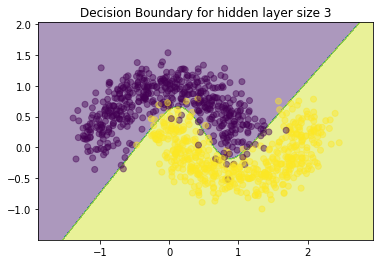

In [6]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)

    
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

# Exercise 1

Add an additional layer to your neural network model. Change the activation function and use a ReLU. Does it work?


Let's start this section by implementing the ReLU function:

In [7]:
def relu(x):
    return np.maximum(0, x)

The above function computes the element-wise maxima of an input array and 0. The input array in this case is the output generated by a hidden layer of the neural network. This way, the output values larger than 0 are kept, while the smaller ones are converted to 0.

Now, we have to adapt the previously defined functions to the new architecture. Since we are using a neural network with two hidden layers and the ReLU activation function, we have to modify the forward propagation algorithm to consider the previously mentioned changes. Also, since we have added one more layer, if we still want to apply regularization, we must also include the weights of this new layer in the expression that computes the loss the same way as the weights of the other layers.

But before that, and for the sake of readability ,let's declare again the parameters that we wil use while training the network:

In [8]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

Now, let's see the new version of the functions:

In [9]:
def forward_propagation(model, X=X):
    # Get parameters from model
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    
    # Forward propagation to calculate our predictions
    # Hidden layer 1 operations
    z1 = np.dot(X,W1) + b1
    a1 = relu(z1)
    
    # Hiden layer 2 operations
    z2 = np.dot(a1,W2) + b2
    a2 = relu(z2)
    
    # Softmax function
    z3 = np.dot(a2, W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    return probs

# Loss
def loss(model):
    # Get parameters from model
    W1, W2, W3, = model['W1'], model['W2'], model['W3']
    
    probs = forward_propagation(model)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    
    return 1./num_examples * data_loss

# Prediction
def predict(model, X):
    probs = forward_propagation(model, X)
    
    return np.argmax(probs, axis=1)

Apart from the previously mentioned changes, we can see that the forward propagation process has been extracted into a separate function called `forward_propagation`. This has been done in order to reduce duplicate code because, as we can see in the previous definitiones, this chunk of code is used both by the `loss` and `predict` functions.

Let's now define the functions that we will use to create and train the model. These two functions are inspired by the previously defined `build_model` function. In this case, however, we are keeping separate the model creation from the training, as they perform different actions.

In [10]:
import copy

# Function used to create a NN with 2 hidden layers
# nn_input_dim: tuple containing the dimensions of the hidden layers
def create_nn_2_hl(nn_input_dim, nn_hdim):
    # Initialize the parameters to random values. 
    np.random.seed(0)
    
    W1 = np.random.randn(nn_input_dim, nn_hdim[0]) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim[0]))
    W2 = np.random.randn(nn_hdim[0], nn_hdim[1]) / np.sqrt(nn_hdim[0])
    b2 = np.zeros((1, nn_hdim[1]))
    W3 = np.random.randn(nn_hdim[1], nn_output_dim) / np.sqrt(nn_hdim[1])
    b3 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    
    return model

# Function used to train the model
def train(model, num_passes=50000, print_loss=False):
    # Perform a deep copy of the model before training it
    train_model = copy.deepcopy(model)
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):
        # Forward propagation
        predict(train_model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(train_model)
        grad_flat, unflatten_g = flatten(gradient_loss(train_model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        train_model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(train_model)))
    
    return train_model

That being said, let's now create a neural network with 2 hidden layers and train it. In this case, we have chosen two hidden layers of size 6 as we believe that they will yield good results.

In [11]:
# Create and train neural network
nn = create_nn_2_hl(nn_input_dim, (6, 6))

model = train(nn, print_loss=True)

Loss after iteration 0: 0.732390
Loss after iteration 1000: 0.330023
Loss after iteration 2000: 0.292365
Loss after iteration 3000: 0.279275
Loss after iteration 4000: 0.271245
Loss after iteration 5000: 0.265723
Loss after iteration 6000: 0.261173
Loss after iteration 7000: 0.256837
Loss after iteration 8000: 0.251656
Loss after iteration 9000: 0.242441
Loss after iteration 10000: 0.225308
Loss after iteration 11000: 0.198126
Loss after iteration 12000: 0.166567
Loss after iteration 13000: 0.141426
Loss after iteration 14000: 0.125112
Loss after iteration 15000: 0.114798
Loss after iteration 16000: 0.108365
Loss after iteration 17000: 0.104326
Loss after iteration 18000: 0.101370
Loss after iteration 19000: 0.099293
Loss after iteration 20000: 0.097751
Loss after iteration 21000: 0.096651
Loss after iteration 22000: 0.095685
Loss after iteration 23000: 0.094946
Loss after iteration 24000: 0.094324
Loss after iteration 25000: 0.093819
Loss after iteration 26000: 0.093410
Loss after ite

We can observe that in this case the model performs slightly better than the original. It starts with a higher initial loss, but after only 3000 iterations its loss is slightly smaller than the original model's. From that point, we can observe that it converges faster than the previous model, since it reaches a loss of $0.1$ in about 18000 iterations, whereas the previous model needed 49000 iterations to reach this point. However, once that point is reached, there is hardly any improvement. We will discuss why this happens later on.

If we observe the rate of convergence of our model, we can clearly see, as we said before, that it converges faster than the original. This increase in the rate of convergence can be attributed to the ReLU function. Since it helps prevent the vanishing gradient problem, it allows the model to learn at a faster rate, and thus, achieve a minimum faster than other functions such as $\tanh$ and the sigmoid function.

Let's plot the decision boundary to have a better understanding on what has changed:

Text(0.5, 1.0, 'Decision Boundary for 2 hidden layers of size (6, 6)')

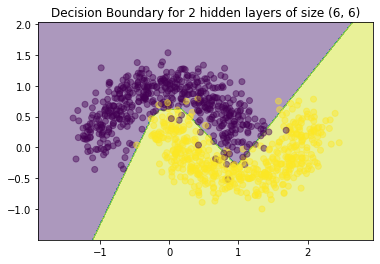

In [12]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for 2 hidden layers of size (6, 6)")

On a first sight, it might appear that there is not a lot of difference with the previous decision boundary. However, after taking a closer look, we can see that it classifies correcly the purple points which are near the left part of the boundary.

It is important to keep in mind that we will never be able perfectly classify each point. This is due to the fact that there exist some noisy points which overlap with points from the other class. We could try more complex and deeper models, but then we run the risk of overfitting.

To conclude this section, we can say that adding a new layer and changing the activation function to ReLU has allowed us to get a slightly better model than the original, and that thanks to the ReLU function, the new model has been able to learn faster than the previous one.

# Exercise 2

Design (change parameters) and train a NN to classify the following dataset. 


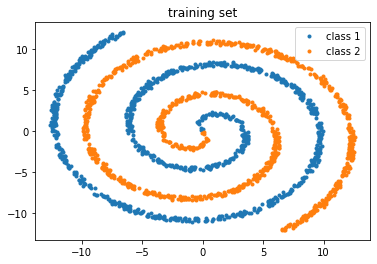

In [13]:
import matplotlib.pyplot as plt

def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points, dtype=np.int32),np.ones(n_points, dtype=np.int32))))

X, y = twospirals(1000)

plt.title('training set')
plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
plt.legend()
plt.show()

Because of the complexity of this problem (points of two different classes that form a helix), we need a more complex model to separate both classes. Thus, we have two options: either to increase the number of nodes per layer, or increase the number of layers, thus making the network deeper.

In this case, we are going to opt for increasing the depth of the network because it will allow us to approximate more complex functions than if we just increased the number of nodes per layer. This doesn't mean, however, that we will not increase the number of nodes per layer compared to the previous cases. Nevertheless, we are always going to prioritize depth over number of nodes per layer.

After a lot of trial and error, we have seen that a neural network with **4 hidden layers** is able to classify the points with very little error. So, in order to create it, we have to redefine the previously defined functions so that they adapt to our new architecture.

Like in the previous case, let's start by redefining the parameters used during the training process:

In [14]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

Now, let's redefine the `forward_propagation`, `loss` and `predict` functions to adapt them to the new architecture:

In [15]:
def forward_propagation(model, X=X):
    # Get parameters from model
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4'], model['W5'], model['b5']
    
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2, W3) + b3
    a3 = relu(z3)
    z4 = np.dot(a3, W4) + b4
    a4 = relu(z4)
    z5 = np.dot(a4, W5) + b5
    exp_scores = np.exp(z5)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    return probs

# Loss
def loss(model):
    # Get parameters from model
    W1, W2, W3, W4, W5 = model['W1'], model['W2'], model['W3'], model['W4'], model['W5']
    
    probs = forward_propagation(model)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)) + np.sum(np.square(W4)) + np.sum(np.square(W5)))
    
    return 1./num_examples * data_loss

# Prediction
def predict(model, X):
    probs = forward_propagation(model, X)
    
    return np.argmax(probs, axis=1)

Next, we are going to create the function that builds the a neural network with 4 hidden layers:

In [16]:
def create_nn_4_hl(nn_input_dim, nn_hdim):
    # Initialize the parameters to random values. 
    np.random.seed(0)
    
    W1 = np.random.randn(nn_input_dim, nn_hdim[0]) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim[0]))
    W2 = np.random.randn(nn_hdim[0], nn_hdim[1]) / np.sqrt(nn_hdim[0])
    b2 = np.zeros((1, nn_hdim[1]))
    W3 = np.random.randn(nn_hdim[1], nn_hdim[2]) / np.sqrt(nn_hdim[1])
    b3 = np.zeros((1, nn_hdim[2]))
    W4 = np.random.randn(nn_hdim[2], nn_hdim[3]) / np.sqrt(nn_hdim[2])
    b4 = np.zeros((1, nn_hdim[3]))
    W5 = np.random.randn(nn_hdim[3], nn_output_dim) / np.sqrt(nn_hdim[3])
    b5 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {
        'W1': W1, 'b1': b1,
        'W2': W2, 'b2': b2,
        'W3': W3, 'b3': b3,
        'W4': W4, 'b4': b4,
        'W5': W5, 'b5': b5
    }
    
    return model

Now that we have all of the necessary functions, let's create our model and train it. After some trial and error, we have arrived to the conclusion that having **4 hidden layers with 10 neurons per layer** allows the model to approximate the target function with a very small error. 

In [17]:
# Create and train the network
nn = create_nn_4_hl(nn_input_dim, (10, 10, 10, 10))
model = train(nn, print_loss=True)

Loss after iteration 0: 0.721729
Loss after iteration 1000: 0.649021
Loss after iteration 2000: 0.638109
Loss after iteration 3000: 0.629946
Loss after iteration 4000: 0.623013
Loss after iteration 5000: 0.618936
Loss after iteration 6000: 0.616446
Loss after iteration 7000: 0.614599
Loss after iteration 8000: 0.613172
Loss after iteration 9000: 0.611908
Loss after iteration 10000: 0.610878
Loss after iteration 11000: 0.610019
Loss after iteration 12000: 0.609078
Loss after iteration 13000: 0.608187
Loss after iteration 14000: 0.607808
Loss after iteration 15000: 0.607053
Loss after iteration 16000: 0.606013
Loss after iteration 17000: 0.604837
Loss after iteration 18000: 0.603694
Loss after iteration 19000: 0.602216
Loss after iteration 20000: 0.600154
Loss after iteration 21000: 0.597163
Loss after iteration 22000: 0.591812
Loss after iteration 23000: 0.584147
Loss after iteration 24000: 0.572964
Loss after iteration 25000: 0.556620
Loss after iteration 26000: 0.534408
Loss after ite

If we observe the above output, we can see that as the number of iterations increase, the loss decreases until it reaches a very low value. We can also observe that at the beginning the loss decreases quite slowly. When it reaches around 26000 iterations, it starts decreasing drastically, until it stabilizes at 33000 iterations and starts decreasing slowly again. This steep increase in the rate of convergence might mean that the model got out of a plateau.

Something that might seem a bit unsettling is the fact that at 30000 iterations the loss is almost the double of the loss at 29000 iterations. However, this is something that might happen from time to time, since the loss might fluctuate while training. Since the general trend of the loss is to decrease, this value of loss can be treated as noise.

Finally, let's plot the decision boundary to have a better insight on how the model is performing:

Text(0.5, 1.0, 'Decision Boundary for 4 hidden layers of size (10, 10, 10, 10)')

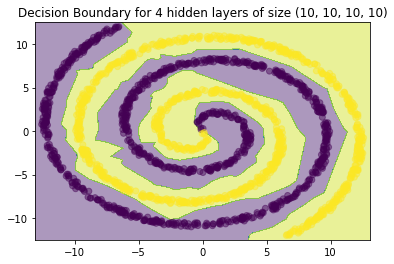

In [18]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for 4 hidden layers of size (10, 10, 10, 10)")

As we can see, the model resembles quite a lot the original function. There seems to be no overfitting, so we can say that this is a good approximation of the goal function.

As a conclusion, we can say that even if there are better models out there that approximate the goal function with less error, this one works really well for this problem since it classifies the points with minimal error. Thus, we can say that this model is good enough for us to solve this classification problem